In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import CMAPSSLoader

In [2]:
loader = CMAPSSLoader()
df = loader.load_dataset('FD003')

Loaded FD003: 24720 records, 100 engines


In [3]:
print(f"Shape: {df.shape}")
print(f"Engines: {df['engine_id'].nunique()}")
df.head()

Shape: (24720, 27)
Engines: 100


,engine_id,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


**Shows**: How much training data exists at each RUL level - this is valuable to assess the data availability for machine learning

**Question**: "How balanced is my training data across the degradation spectrum?"

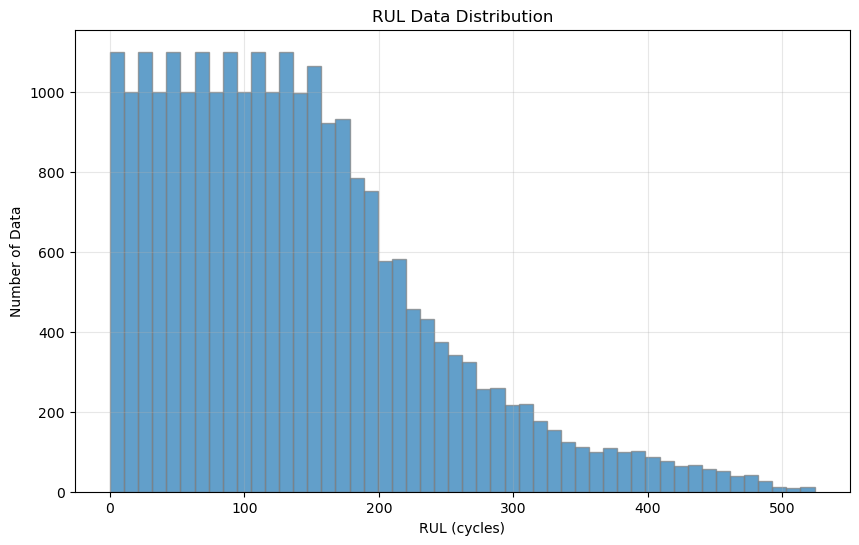

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(df['RUL'], bins=50, alpha=0.7, edgecolor='grey')
plt.title('RUL Data Distribution')
plt.xlabel('RUL (cycles)')
plt.ylabel('Number of Data')
plt.grid(True, alpha=0.3)
plt.show()

**Shows**: How long each individual engine lasted - answers the actual engineering problem

**Question**: "What's the typical lifespan of engines in my fleet?"

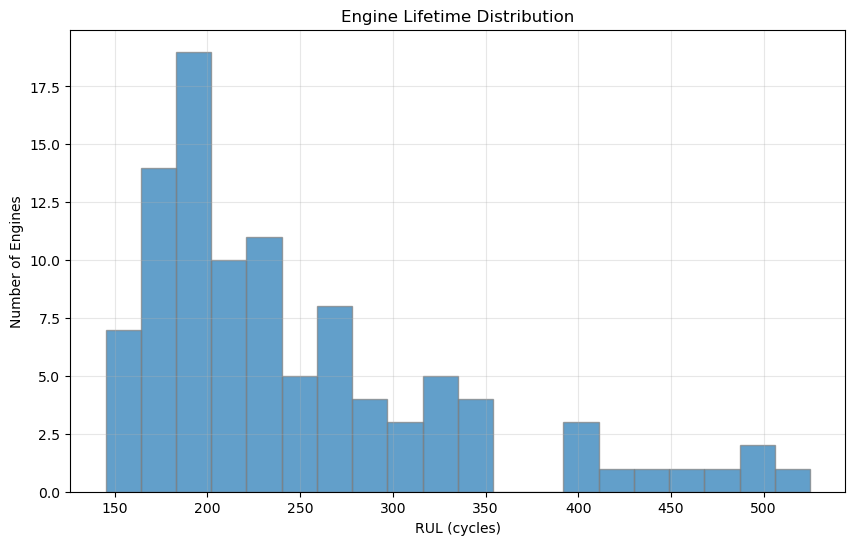

In [5]:
engine_lifetimes = df.groupby('engine_id')['time_cycles'].max()

plt.figure(figsize=(10, 6))
plt.hist(engine_lifetimes, bins=20, alpha=0.7, edgecolor='grey')
plt.title('Engine Lifetime Distribution')
plt.xlabel('RUL (cycles)')
plt.ylabel('Number of Engines')
plt.grid(True, alpha=0.3)
plt.show()

## Correlation Heatmap of Sensors
* **What it shows**: Pairwise correlation between all sensors. Red = strong positive correlation, blue = strong negative.

* **Why valuable**:

    * CMAPSS has many redundant sensors. Highly correlated sensors add little new information (they may be dropped).

    * Completely uncorrelated sensors may be uninformative or noise.

    * This helps dimension reduction and avoids overfitting.

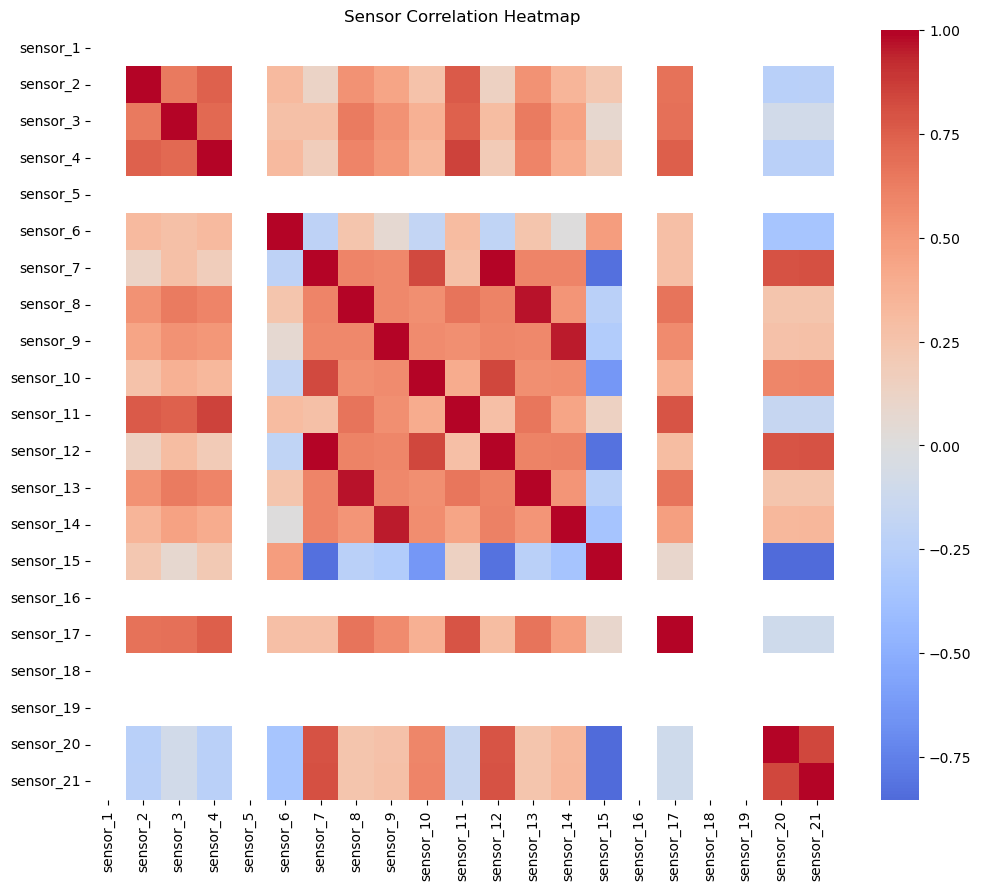

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df[[c for c in df.columns if 'sensor' in c]].corr(), cmap='coolwarm', center=0)
plt.title("Sensor Correlation Heatmap")
plt.show()

## Engine Sensor Time-Series

* **What it shows**: How selected sensor values evolve over cycles for one engine (e.g., engine_id=1).

* **Why valuable**:

    * You can see degradation patterns: some sensors drift steadily as the engine wears, others fluctuate randomly.

    * Identifies which sensors are potential “health indicators.”

    * This visualization is often the first clue about which signals should be engineered into features.

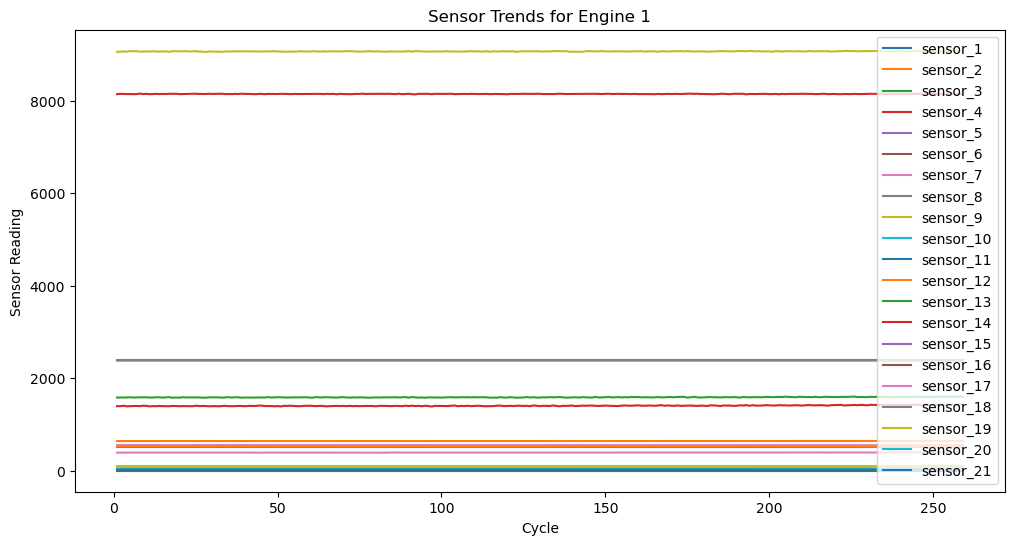

In [7]:
engine = 1
subset = df[df.engine_id == engine]
plt.figure(figsize=(12,6))
for s in [f'sensor_{i}' for i in range(1,22)]:
    plt.plot(subset['time_cycles'], subset[s], label=s)
plt.legend()
plt.title(f'Sensor Trends for Engine {engine}')
plt.xlabel("Cycle"); plt.ylabel("Sensor Reading")
plt.show()

## Operational Settings Distribution

* **What it shows**: Histograms of the three operating condition variables.

* **Why valuable**: Engines don’t always operate under the same conditions; settings can affect sensor behavior and degradation speed.


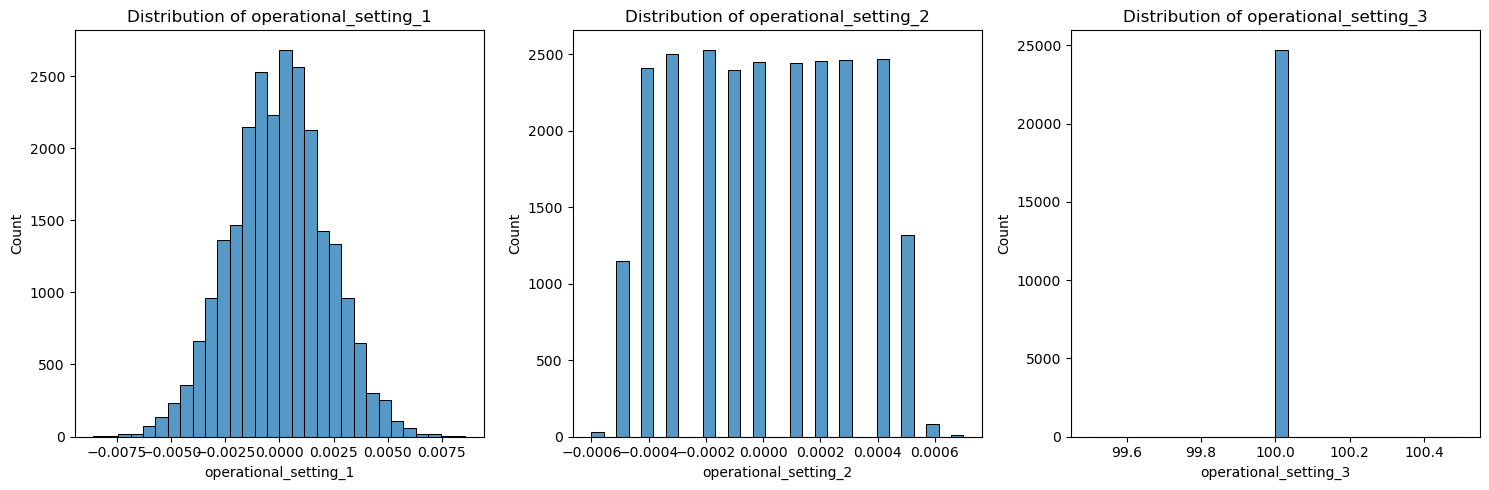

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, col in enumerate([f'operational_setting_{j}' for j in range(1,4)]):
    sns.histplot(df[col], bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

## Sensor Vs. RUL Scatter

* **What it shows**: Relationship between a single sensor reading and the Remaining Useful Life.

* **Why valuable**:

    * Sensors that show a clear monotonic trend with RUL (e.g., values increase/decrease as RUL decreases) are predictive.

    * Scatter plots help identify sensors that correlate with failure timing vs. those that are just noise.

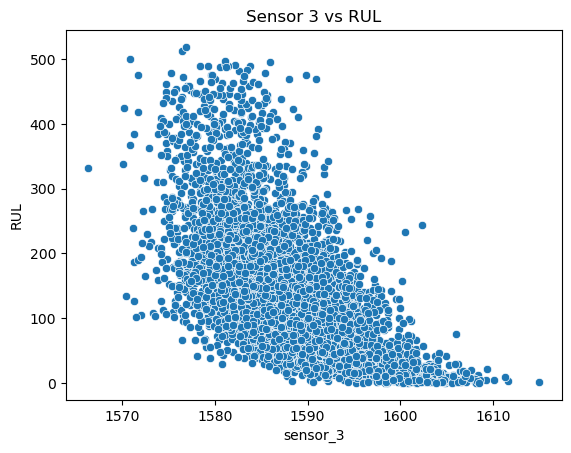

In [9]:
sns.scatterplot(x='sensor_3', y='RUL', data=df.sample(5000))
plt.title("Sensor 3 vs RUL")
plt.show()


## Normalized Lifecycle Plots

* **What it shows**: Sensor trajectories averaged across engines, aligned by normalized cycle (0=start, 1=end-of-life).

* **Why valuable**:

    * Without normalization, engines run at different cycle counts, so trends are hard to compare.

    * Normalization reveals consistent degradation patterns across engines.

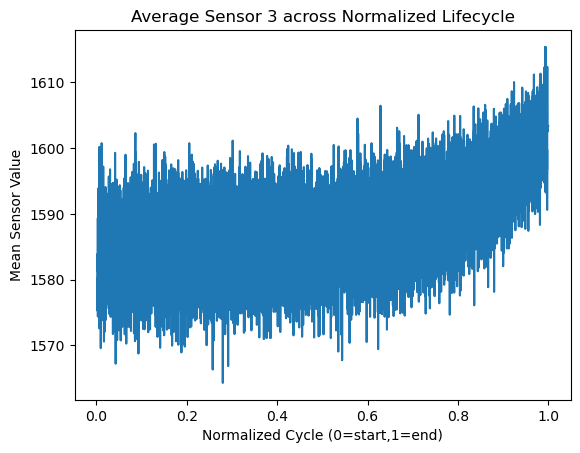

In [10]:
normed = df.copy()
normed['cycle_norm'] = normed.groupby('engine_id')['time_cycles'].transform(
    lambda x: x / x.max()
)

avg_trend = normed.groupby('cycle_norm')['sensor_3'].mean()

plt.plot(avg_trend.index, avg_trend.values)
plt.title("Average Sensor 3 across Normalized Lifecycle")
plt.xlabel("Normalized Cycle (0=start,1=end)")
plt.ylabel("Mean Sensor Value")
plt.show()
